# What's Cooking (Recipe Classification)

## Introduction

- **In this project, there are two json files that involve data about ingredients of recipes, it contains information such as id of  the cuisine and ingredients of that particular cuisine**
- The file `train.json` contains all the training data, it includes an entry labeled `cuisine`, which indicates what type of cuisine it is based on the ingredients. This is the target variable I will use to classify on test data.
- The file `test.json` includes testing data with all the entries except `cuisine`. The goal is to specify the cusinie based on the ingredients listed.

### Project Workflow Overview

**This project will be proceed in several steps outlined below for clarity and organization:**

1. Exploratory Data Analysis (EDA)
2. Data Preprocessing
3. Feature Engineering
4. Data Transformation
5. Fitting the model
6. Model Evaluation
7. Hyperparameters Tuning
8. Predictions on Test Dataset

### Import the Libraries

In [ ]:
# Data Manipulation Libraries
import numpy as np
import pandas as pd
import re

# Data Visulaization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
from scipy import stats

# Sklearn Libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

## Step 1: Exploratory Data Analysis (EDA)

- In this section, I will perform some exploratory data analysis to understand the data.

### Reading the Datasets
- Here, the downloaded dataset is imported and read into a DataFrame using the `pandas` package.

In [ ]:
# Reading the datasets
train_df = pd.read_json('<training_data_path>')
test_df = pd.read_json('<test_data_path>')

- The training DataFrame is then examined using the `head()` method from `pandas`, as shown in the code below:

In [ ]:
# Printing the head of the dataframe
train_df.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


- Next, I will check the number of rows and columns to determine the size of the DataFrame and gain insight into the dataset.

In [ ]:
# Checking the shape of the dataframe
train_df.shape

(39774, 3)

**This indicates that the dataset contains 39774 records (rows) and 3 columns (features).**

### Viewing the Summary of the Dataset

In [ ]:
# Printing the summary of the dataframe
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           39774 non-null  int64 
 1   cuisine      39774 non-null  object
 2   ingredients  39774 non-null  object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB


### Checking the minimum and maximum number of ingredients in Training Dataframe

In [ ]:
#Check Maximum and Minimum number of ingredients in a dish
print('Maximum Number of Ingredients in a Dish: ',train_df['ingredients'].str.len().max())
print('Minimum Number of Ingredients in a Dish: ',train_df['ingredients'].str.len().min())

Maximum Number of Ingredients in a Dish:  65
Minimum Number of Ingredients in a Dish:  1


### Checking for Duplicated Entries in Training Dataframe

In [ ]:
# Check for duplicate IDs
duplicate_ids = train_df[train_df['id'].duplicated()]

# Print the count of duplicate IDs
print(f"Number of duplicate IDs in Training: {duplicate_ids.shape[0]}")

Number of duplicate IDs in Training: 0


**There are no duplicate id's present in the training data.**

### Visualizing different features of the dataframe

- In this section, I will analyze ingredients and cuisine column to understand the data visually.

#### Checking the column `ingredients`

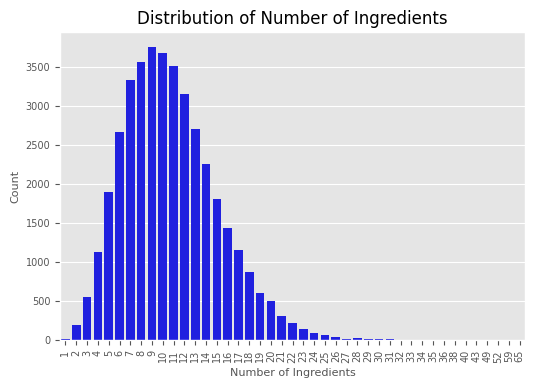

In [ ]:
# Calculate the number of ingredients for each dish
train_df['num_ingredients'] = train_df['ingredients'].str.len()

# Plotting the count of dishes by number of ingredients
plt.figure(figsize=(6, 4))
sns.countplot(x='num_ingredients', data=train_df, color='blue')
plt.title('Distribution of Number of Ingredients', fontsize=12)
plt.xlabel('Number of Ingredients', fontsize=8)
plt.ylabel('Count', fontsize=8)
plt.xticks(rotation=90, fontsize=7)
plt.yticks(fontsize=7)
plt.show()

#### Checking the column `cuisine`

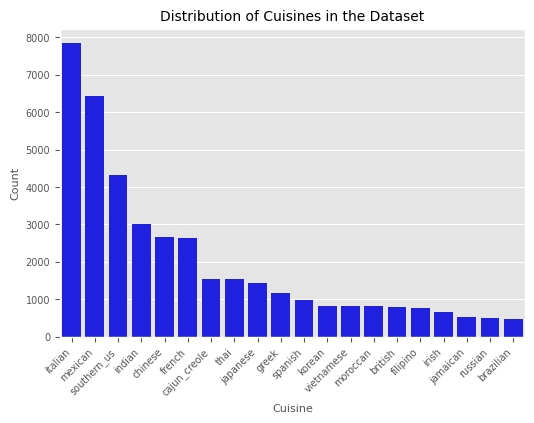

In [ ]:
# Plotting the count of dishes by cuisine
plt.figure(figsize=(6, 4))
sns.countplot(x='cuisine', data=train_df, order=train_df['cuisine'].value_counts().index, color='blue')
plt.title('Distribution of Cuisines in the Dataset', fontsize=10)
plt.xlabel('Cuisine', fontsize=8)
plt.ylabel('Count', fontsize=8)
plt.xticks(rotation=45, fontsize=7, ha='right')
plt.yticks(fontsize=7)
plt.show()

## Step 2: Data Preprocessing

### Dealing with Missing Values

First, I will be checking the number of Null Values in all the columns.

In [ ]:
# Check for missing or empty 'ingredients'
missing_ingredients = train_df[train_df['ingredients'].isna() | (train_df['ingredients'].str.len() == 0)]
if missing_ingredients.empty:
    print("No missing or empty ingredients.")
else:
    print(f"Number of rows with missing or empty ingredients: {len(missing_ingredients)}")

No missing or empty ingredients.


In [ ]:
# Check for missing 'id'
missing_ids = train_df[train_df['id'].isna()]
if missing_ids.empty:
    print("No missing IDs.")
else:
    print(f"Number of rows with missing IDs: {len(missing_ids)}")

No missing IDs.


In [ ]:
# Check for missing or empty 'cuisines'
missing_cuisines = train_df[train_df['cuisine'].isna() | (train_df['cuisine'].str.len() == 0)]
if missing_cuisines.empty:
    print("No missing or empty cuisines.")
else:
    print(f"Number of rows with missing or empty cuisines: {len(missing_cuisines)}")

No missing or empty cuisines.


### Removal of Unnecessary information from the `ingredients` column in training data

Removing characters which are expections other than the special characters

In [ ]:
# Removing Special Charater exceptions
character_exceptions_to_remove = ["\xae", "\xe8vre", "\u2122", "\xada", "\xadn", "¬s", "Ã£", "Ã", "£"]

Removing the phrases which have a single word and without any spaces between them

In [ ]:
# Removing the phrases with a single word without spaces
phrase_exceptions = [("7 up", "sevenup"), ("sun dried", "sundried"),
                     ("bone less", "boneless"), ("skin less", "skinless")]

Handling the plural words in the ingredients part of the dataset

In [ ]:
# Handling plural values in the dataset
deal_plural_singular = [("steaks", "steak"), ("loins", "loin"), ("inches", "inch"), ("centimeters", "centimeter"),
                          ("ounces", "ounce"), ("liters", "liter"), ("mililiters", "mililiter"), ("grams", "gram"),
                          ("cups", "cup"), ("gallons", "gallon"), ("quarts", "quart"), ("lbs", "lb"),
                          ("pounds", "pound"), ("tablespoons", "tablespoon"), ("teaspoons", "teaspoon"),
                          ("pints", "pint"), ("fluid ounces", "fluid ounce"), ("onions", "onion"),
                          ("cloves", "clove"), ("bulbs", "bulb"), ("peppers", "pepper"), ("breasts", "breast"),
                          ("eggs", "egg"), ("carrots", "carrot"), ("mushrooms", "mushroom"),
                          ("tortillas", "tortilla"), ("sausages", "sausage"), ("wedges", "wedge"),
                          ("tomatoes", "tomato"), ("thighs", "thigh"), ("chilies", "chili"), ("potatoes", "potato"),
                          ("peppercorns", "peppercorn"), ("spices", "spice"), ("chiles", "chile"), ("apples", "apple"),
                          ("legs", "leg"), ("doughs", "dough"), ("drumsticks", "drumstick"), ("radishes", "radish"),
                          ("seeds", "seed"), ("pears", "pear"), ("sausages", "sausage")]

Removing of the brand names from the ingredients in the dataset

In [ ]:
# Removing Brand names in the dataset. This is important since same ingredient can be from different brands
brandnames_to_remove = ["Lea & Perrins", "Lea and Perrin", "Lea and Perrins", "alexia", "breakstones",
                        "kraft", "bertolli classico", "bertolli", "best foods",
                        "betty crocker", "bisquick", "bob evans", "breyers", "curry guy", "camellia", "campbells",
                        "country crock", "crisco", "crystal farms", "delallo", "diamond crystal", "domino",
                        "doritos", "earth balance", "egglands best", "foster farms", "franks", "gold medal",
                        "goya", "green giant steamers niblets", "green giant", "heinz", "hellmanns", "herdez",
                        "hidden valley", "honeysuckle white", "jacksonville",  "jimmy dean", "johnsonville",
                        "knorr", "krudsen", "kikkoman", "lipton", "land o lakes", "mazola", "lea and perrins",
                        "mccormick", "meyer", "mission", "old el paso", "old bay", "pam", "pepperidge farm",
                        "oscar mayer", "pace", "pillsbury", "progresso", "pure wesson", "pompeian", "san marzano",
                        "sargento", "soy vay", "taco bell", "yoplait", "spice islands", "stonefire", "success",
                        "swanson", "truvía", "uncle bens", "wish bone", "zatarains", "morton", "jameson", "tapatio",
                        "mountain high", "philadelphia", "king arthur", "roma", "wolf brand", "tabasco", "mrs. dash seasoning mix",
                        "BACARDI®", "Barilla", "Bertolli", "Bertolli®", "Best Food's", "Campbell's", "CURRY GUY",
                        "Crystal Farms", "DeLallo", "Gourmet Garden", "Goya", "Hellmann''s",
                        "Hellmann's", "Hellmann's®", "Herdez", "Hidden Valley®", "I Can't Believe It's Not Butter!® ",
                        "JOHNSONVILLE","Johnsonville", "KRAFT"," Velveeta", "Best Foods®", "Bisquick", "Diamond Crystal®", "Eggland's Best®",
                        "Green Giant™", "Guinness", "Haas", "Hatch", "Holland House", "Imperial", "Jarlsberg", "Jell-O", "Jif Creamy",
                        "Jiffy", "Kahlua", "Karo", "Kerrygold", "La Victoria", "Land O Lakes®", "Lea & Perrins", "Louisiana", "M&M's",
                        "Mae Ploy", "Makers Mark", "Manischewitz", "Minute", "Mizkan", "Nakano", "Neapolitan", "Nestle", "Nilla",
                        "New York Style Panetini®", "Nido", "Nielsen-Massey", "Niçoise", "OREO®", "oreo", "Piment d'Espelette", "Poire Williams",
                        "Ragu", "Ragu® Robusto!®", "Ranch Style", "Reblochon", "Red Gold®", "Rice Krispies", "Ritz", "Ro-Tel", "Rotel", "Royal",
                        "San Marzano", "Skippy", "Smithfield", "Smart Balance", "Southern Comfort", "Soy Vay®", "St Germain", "TABASCO®", "Tyson",
                        "Tuttorosso", "Tipo 00", "Truvía®", "Tuaca", "White Lily", "Wish-Bone®", "Wish-Bone", "Wolf Brand", "Yakisoba", "Yoplait®",
                        "Zatarains", "Zatarain's"]

Removing the words which does not provide any meaningful insight

In [ ]:
# Removing certain key words that do not add any valuable information to the ingredient
keywords_to_remove = ["drained and chopped", "lowfat", "light", "shredded", "sliced", "all purpose", "all natural", "natural", "original",
                      "gourmet", "traditional", "boneless", "skinless", "fresh", "nonfat", "pitted", "quick cooking",
                      "unbleached", "part skim", "skim", "quickcooking", "oven ready", "homemade", "instant", "small",
                      "extra large", "large", "chopped", "grated", "cooked", "stone ground", "freshly ground",
                      "ground", "pure", "peeled", "deveined", "organic", "cracked", "granulated", "inch thick",
                      "extra firm", "crushed", "flakes", "self rising", "diced", "crumbles", "crumbled",
                      "whole wheat", "whole grain", "baby", "medium", "plain", "of", "thick cut", "cubed", "coarse",
                      "free range", "seasoned", "canned", "multipurpose", "vegan", "thawed", "squeezed",
                      "vegetarian", "fine", "zesty", "halves", "firmly packed", "drain", "drained", "washed", "any", "asian", "assam", "black",
                      "browning", "frosting", "game", "hand", "hen of the woods", "and", "grained", "half & half",
                      "i can't believ it' not butter! made with olive oil spread", "less sodium", "43", "cook", "drain", "tradicional", "no",
                      "no calorie", "meal", "style", "in" , "or", "points", "v 8", "v8", "dressing", "real", "with", "shortening",
                      "fine", "chop", "clear", "of", "finely", "thawed", "undiluted", "concentrate", "full",
                      "fully", "secret", "moisture", "angel hair", "less", "cut", "into", "Original", "a", "with a TOUCH OF PHILADELPHIA"]

Removing the words which include measurements as they don't add any value

In [ ]:
# Removing measurements as this would not add any information
measurements_to_remove = ["in", "inch", "cm", "centimeter", "oz", "ounce", "l", "liter", "ml", "mililiter", "g",
                          "gram", "cup", "gallon", "quart", "lb", "pound", "tbsp", "tablespoon", "tsp", "teaspoon",
                          "pint", "fl oz", "fluid ounce", "ounc"]

Removing the special characters from ingredients in the dataset

In [ ]:
# Removing the special characters
replace_punc_space = re.compile(r"[-,]")
remove_percentage_less = re.compile(r"[\d+]% less [A-z]*")
remove_percentage_reduced = re.compile(r"[\d+]% reduced [A-z]*")
remove_special_char = re.compile(r"[!\\/%.'®™Ã£Âº©¢()â€žÂ¢â€™„¢¨â‚¬§]")
remove_digits = re.compile(r"\d+")
replace_symbols_and = re.compile(r"[&+]")
remove_parantheses_content = re.compile(r"\([^)]*\)")
remove_betweeen_no_added = re.compile(r"no [A-z]* added")
remove_reduced_word = re.compile(r"reduced [A-z]*")
remove_low_and_following_word = re.compile(r"low [A-z]*")
remove_less_and_following_word = re.compile(r"less [A-z]*")
remove_free_and_previous_word = re.compile(r"[A-z]* free")
trim_multi_spaces = re.compile(r" +")

Creating a unified list of terms to be removed and storing it in `phrases_to_remove`

In [ ]:
phrases_to_remove = measurements_to_remove + keywords_to_remove + brandnames_to_remove

### Mapping of different terms used for the same ingredient in training data

Mapping phrases that differ but refer to the same ingredient

In [ ]:
# Mapping different phrases used to for the same ingredients
phrases_to_map = [
    (("green onion", "red onion", "purple onion", "yellow onion", "yel onion"), "onion"),
    (("accent seasoning"), "accent"),
    (("arrow root"), "arrowroot"),
    (("mahi mahi"), "mahimahi"),
    (("mahi mahi fillets", "mahimahi fillet")),
    (("filets"), "fillets"),
    (("buffalo mozarella"), "buffalo mozzarella"),
    (("collard green leaves", "collards", "collard leaves"), "collard greens"),
    ("black pepper", "pepper"),
    ("yel chives", "chives"),
    ("spinach leaves", "spinach"),
    (("clams, well scrub"), "clams"),
    ("tea leaves", "tea"),
    ("chile", "chili"),
    (("garlic clove", "garlic bulb"), "garlic"),
    ("uncooked", "raw"),
    (("red chili pepper", "hot chili pepper", "red hot chili pepper"), "chili pepper"),
    (("baking potato", "baked potato"), "baked potato"),
    (("sea salt", "kosher salt", "table salt", "white salt", "sea salt flakes"), "salt"),
    ("scotch whiskey", "scotch"),
    (("i cant believe its not butter spread", "i cant believe its not butter", "softened butter", "melted butter", "salted butter"), "butter"),
    (("extra virgin olive oil", "virgin olive oil"), "olive oil"),
    (("white bread", "wheat bread", "grain bread"), "bread"),
    (("white sugar", "yel sugar"), "sugar"),
    ("confectioners sugar", "powdered sugar"),
    (("whole wheat spaghetti noodles", "whole wheat spaghettini"), "whole wheat spaghetti"),
    ("white tuna in water", "white tuna"), (("white bread slices", "white bread crumbs"), "white bread"),
    (("whipped cream", "whipped topping", "whipping cream", "whipping heavy cream", "whipped topping"), "whipped cream"),
    ("water chestnut powder", "water chestnuts"), (("walnut halves", "walnut pieces"), "walnuts"),
    ("waffle fries", "waffle"), ('deli ham', 'ham'), ('taco seasoning mix', 'taco seasoning'),("chees", "cheese"), ("sauc", "sauce"),
    ("paneer cheese", "paneer"), ("aleppo", "aleppo pepper"), ("all potato purpos", "potato"),
    ("Jamaican allspice", "allspice pepper"), ("allspice", "allspice pepper"),
    ("zucchini blossoms", "zucchini"), ("yukon gold", "yukon gold potatoes"), ("yellowfin", "yellowfin tuna"),
    ("yellow summer squash", "yellow squash"), ("yellow mustard seeds", "yellow mustard"),
    ("whole wheat tortilla wraps", "whole wheat tortilla"), ("vermicelli noodles", "vermicelli"), ("veggies", "vegetables"),
    (("vegetable oil cooking spray", "vegetable oil spray"), "vegetable oil"),
    (("vegetable soup", "vegetable stock", "vegetable stock powder", "vegetable slaw"), "vegetable broth"),
    (("vanilla essence", "vanilla flavoring", "vanilla"), "vanilla extract"), ("vanilla bean", "vanilla beans"),
    ("urad dal split", "urad dal"), (("original converted brand rice", "ready rice whole grain brown rice"), "rice"),
    ("turnip greens", "turnips"), ("turmeric root", "tumeric"), (("tortilla wraps", "tortilla shells"), "tortillas"),
    (("tortelloni", "tortellini, cook and drain"), "tortellini"), ("top sirloin steak", "top sirloin"),
    (("thyme", "thyme leaves", "thyme sprig", "thyme sprigs"), "thyme"), ("spinach leaves", "spinach"),
    (("spaghetti squash","spaghetti, cook and drain", "spaghettini"), "spaghetti"), ("sliced mushrooms", "mushrooms"),
    (("sesame", "sesame paste", "sesame seed paste", "toasted sesame seeds", "roasted sesame seeds"), "sesame seeds"),
    (("dark sesame oil", "toasted sesame oil"), "sesame oil"), ("serrano chilies", "serrano chile"),
    ("scallion greens", "scallions"), (("saffron powder", "saffron threads"), "saffron"),
    (("asafetida (powder), asafetida powder"), "asafoetida powder"),
    (("asafetida"), "asafoetida"),
    (("sauc"), "sauce"),
    (("chees"), "cheese")]

## Step 3: Feature Engineering

### Cleaning training and the test data

- Defining a function to remove the unnecessary information from the dataset by cleaning the each ingredient

In [ ]:
# Function to clean a single ingredient string
def clean_column(ingredient):
    ingredient = ingredient.lower()
    ingredient = replace_punc_space.sub(" ", ingredient)

    # Map and remove specific exceptions
    for character_exception in character_exceptions_to_remove:
        ingredient = re.sub(character_exception, "", ingredient)
    for phrase_exception, replacement in phrase_exceptions:
        ingredient = re.sub(r"\b{}\b".format(phrase_exception), replacement, ingredient)

    # Remove phrases indicating percentages
    ingredient = remove_percentage_less.sub("", ingredient)
    ingredient = remove_percentage_reduced.sub("", ingredient)

    # Remove special characters and digits
    ingredient = remove_special_char.sub("", ingredient)
    ingredient = remove_digits.sub("", ingredient)

    # Replace symbols like "&" with "and"
    ingredient = replace_symbols_and.sub(" and ", ingredient)

    # Remove content inside parentheses
    ingredient = remove_parantheses_content.sub(" ", ingredient)

    # Remove phrases like "no added" followed by specific words
    ingredient = remove_betweeen_no_added.sub("", ingredient)

    # Remove occurrences of the word "reduced"
    ingredient = remove_reduced_word.sub("", ingredient)

    # Remove phrases containing words like "low" or "less"
    ingredient = remove_low_and_following_word.sub("", ingredient)
    ingredient = remove_less_and_following_word.sub("", ingredient)

    # Remove phrases like "free" and the preceding word
    ingredient = remove_free_and_previous_word.sub("", ingredient)

    # Replace multiple spaces with a single space
    ingredient = trim_multi_spaces.sub(" ", ingredient)

    # Standardize plural to singular forms
    for plural, singular in deal_plural_singular:
        ingredient = re.sub(r"\b{}\b".format(plural), singular, ingredient)

    # Remove predefined phrases that are not needed
    for phrase in phrases_to_remove:
        ingredient = re.sub(r"\b{}\b".format(phrase), "", ingredient)

    for pattern, replacement in phrases_to_map:
        if type(pattern) is tuple:
            for val in pattern:
                ingredient = re.sub(r"\b{}\b".format(val), replacement, ingredient)
        elif type(pattern) is str:
            ingredient = re.sub(r"\b{}\b".format(pattern), replacement, ingredient)

    # Replace multiple spaces with a single space and strip leading/trailing spaces
    ingredient = trim_multi_spaces.sub(" ", ingredient)
    ingredient = ingredient.strip()
    return ingredient

# Function to clean a list of ingredients in a recipe
def clean_recipe(recipe):
    recipe = list(map(clean_column, recipe))
    recipe = [ingredient for ingredient in recipe if len(ingredient) > 0]
    return recipe

# Function to clean the raw dataset containing recipes
def clean_raw_data(raw_data):
    clean_data = raw_data['ingredients'].apply(clean_recipe)
    return clean_data


#### Storing the clean ingredients back to the train and test dataset

In [ ]:
# Storing the clean ingredients
train = clean_raw_data(train_df)
test = clean_raw_data(test_df)

In [ ]:
# Assigning the clean ingredients data into the dataset
train_df['ingredients'] = train
test_df['ingredients'] = test
type(train_df['ingredients'][0])

# Combines Ingredient lists into Strings
train_df['seperated_ingredients'] = train_df['ingredients'].apply(','.join)
test_df['seperated_ingredients'] = test_df['ingredients'].apply(','.join)

## Step 4: Data Transformation

### Transformation of the data present in the dataframe

**In this section, I will be transforming texutual data into numerical format by using `TF-IDF Vectorization` on ingredients and `Label Encoder` on cuisine**

#### TF-IDF Vectorization

- `TF-IDF (Term Frequency-Inverse Document Frequency) vectorization` is a statistical technique used in text mining and natural language processing (NLP) to convert text data into numerical feature vectors.
- It evaluates the importance of terms (words or tokens) within a document relative to a collection of documents (corpus).
- TF-IDF helps highlight important words in each document while reducing the weight of common but less meaningful words.

In [ ]:
# Initialize the TF-IDF Vectorizer
vect = TfidfVectorizer(binary=True).fit(train_df['seperated_ingredients'].values)

In [ ]:
# Transform the Training Data
X_train = vect.transform(train_df['seperated_ingredients'].values)
X_train = X_train.astype('float')

In [ ]:
# Transform the Testing Data
X_test = vect.transform(test_df['seperated_ingredients'].values)
X_test = X_test.astype('float')

#### Label Encoder
- `Label Encoder` is a tool used to convert categorical data into numerical format for machine learning models.
- It assigns a unique integer to each unique category in the data.
- It is best suited for ordinal data or cases where no relationships between categories are assumed.
- Label Encoded data can be easily transformed back to the original categories using the inverse_transform() method.

In [ ]:
# Initialize the Label Encoder
encoder = LabelEncoder()

# Fit and Transform the target column
y_train = encoder.fit_transform(train_df.cuisine)

## Step 5: Fitting the model
- **In this step, I will fit ML models to the DataFrame and select the final model based on the best score from the validation set.**

### Training-Validation Step
- In this step, I will split the training DataFrame into two subsets for cross-validation.

In [ ]:
# Train-Valid split
X_train_small, X_valid, y_train_small, y_valid = train_test_split(X_train, y_train, test_size = 0.2, random_state = 0)

In [ ]:
# Checking Both Shapes
print(f"Shape of Training X: {X_train_small.shape}")
print(f"Shape of Validation X: {X_valid.shape}")

Shape of Training X: (31819, 2773)
Shape of Validation X: (7955, 2773)


### Fitting the Training Data now on different Models

In [ ]:
# Defining Models Dictionary
models = {
    'SVC': SVC(),
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=200)
}

# For loop for all the models
for name, model in models.items():

    # Train the model on the small training set
    model.fit(X_train_small, y_train_small)

    # Predict on the validation set
    y_pred = model.predict(X_valid)

    # Calculate accuracy score
    score = accuracy_score(y_valid, y_pred)
    print(f"{name} Validation Score: {score:.4f}\n")

SVC Validation Score: 0.8033

Random Forest Validation Score: 0.7566

Logistic Regression Validation Score: 0.7886



### FINAL MODEL

- **Based on accuracy score of the models, I will be selecting `Support Vector Classifier` as final model.**
- **This choice reflects the model's ability to minimize error and enhance predictive accuracy.**

#### Model: Support Vector Classifier

**Support Vector Classifier (SVC) is a machine learning algorithm used for classification tasks.**

- It works by finding a hyperplane that best separates different classes while maximizing the margin between them.
- SVC can handle both linear and non-linear data by using kernel functions, such as the Radial Basis Function (RBF) kernel, to map data into higher-dimensional spaces where a linear separation is possible.
- The model's performance can be controlled using parameters like C (regularization) and gamma (influence of individual data points).
- SVC is effective in high-dimensional spaces but can be computationally expensive for large datasets.

## Step-6: Hyperparameter Optimization/Tuning

- In this step, the final **hyperparameter tuning** will be applied to *Support Vector Classifier* using the smaller training dataset to find the optimal parameters.

### Support Vector Classifier Tuning

In [ ]:
# Base Model
model_svc = SVC()

In [ ]:
param_grid = {
    'C':[1,10, 20],
    'gamma':[1,0.1],
    'kernel':['linear','rbf']
    }

grid_search = GridSearchCV(model_svc, param_grid = param_grid, cv = 3, verbose=3, n_jobs=-1)

In [ ]:
# Fitting on the entire small Training Data
svc_grid = grid_search.fit(X_train_small, y_train_small)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


In [ ]:
# Best Model
best_svc = svc_grid.best_estimator_
best_svc

SVC(C=10, gamma=1)

## Step 7: Evaluation of Validation Set

- In this section, I will be evaluating the model on the Training and Validation Data with the best estimators.

In [ ]:
# Best SVC
svc_clf = best_svc

# Fitting on the small Training Dataframe
svc_clf.fit(X_train_small, y_train_small)

# Predicting the Validation set
pred_valid = svc_clf.predict(X_valid)

# Calculate accuracy score
score = accuracy_score(y_valid, pred_valid)
print(f"Validation Score: {score:.4f}\n")

Validation Score: 0.8118



## Step 8: Predictions on Test Data

- In this section, best model that is already fitted will be used to predict on test set.

In [ ]:
# Fitting on Entire Training Dataset
svc_clf.fit(X_train, y_train)

SVC(C=10, gamma=1)

In [ ]:
# Predictions of test set
predictions = svc_clf.predict(X_test)

In [ ]:
# Inverse Transform Predictions
predictions_final = encoder.inverse_transform(predictions)

# Create a DataFrame for Predictions
predictions = pd.DataFrame({'cuisine': predictions_final, 'id': test_df.id})
predictions = predictions[['id', 'cuisine']]

In [ ]:
# Save Predictions to a CSV file
predictions.to_csv('submission_SVC.csv', index=False)

- **When I submitted the file `submission_SVC.csv` on the Kaggle, I got `0.81063` as the score*(Support Vector Classifier)***
- **NOTE**: Was not able to submit the score to the leaderboard as its past the deadline and the submission is disabled.

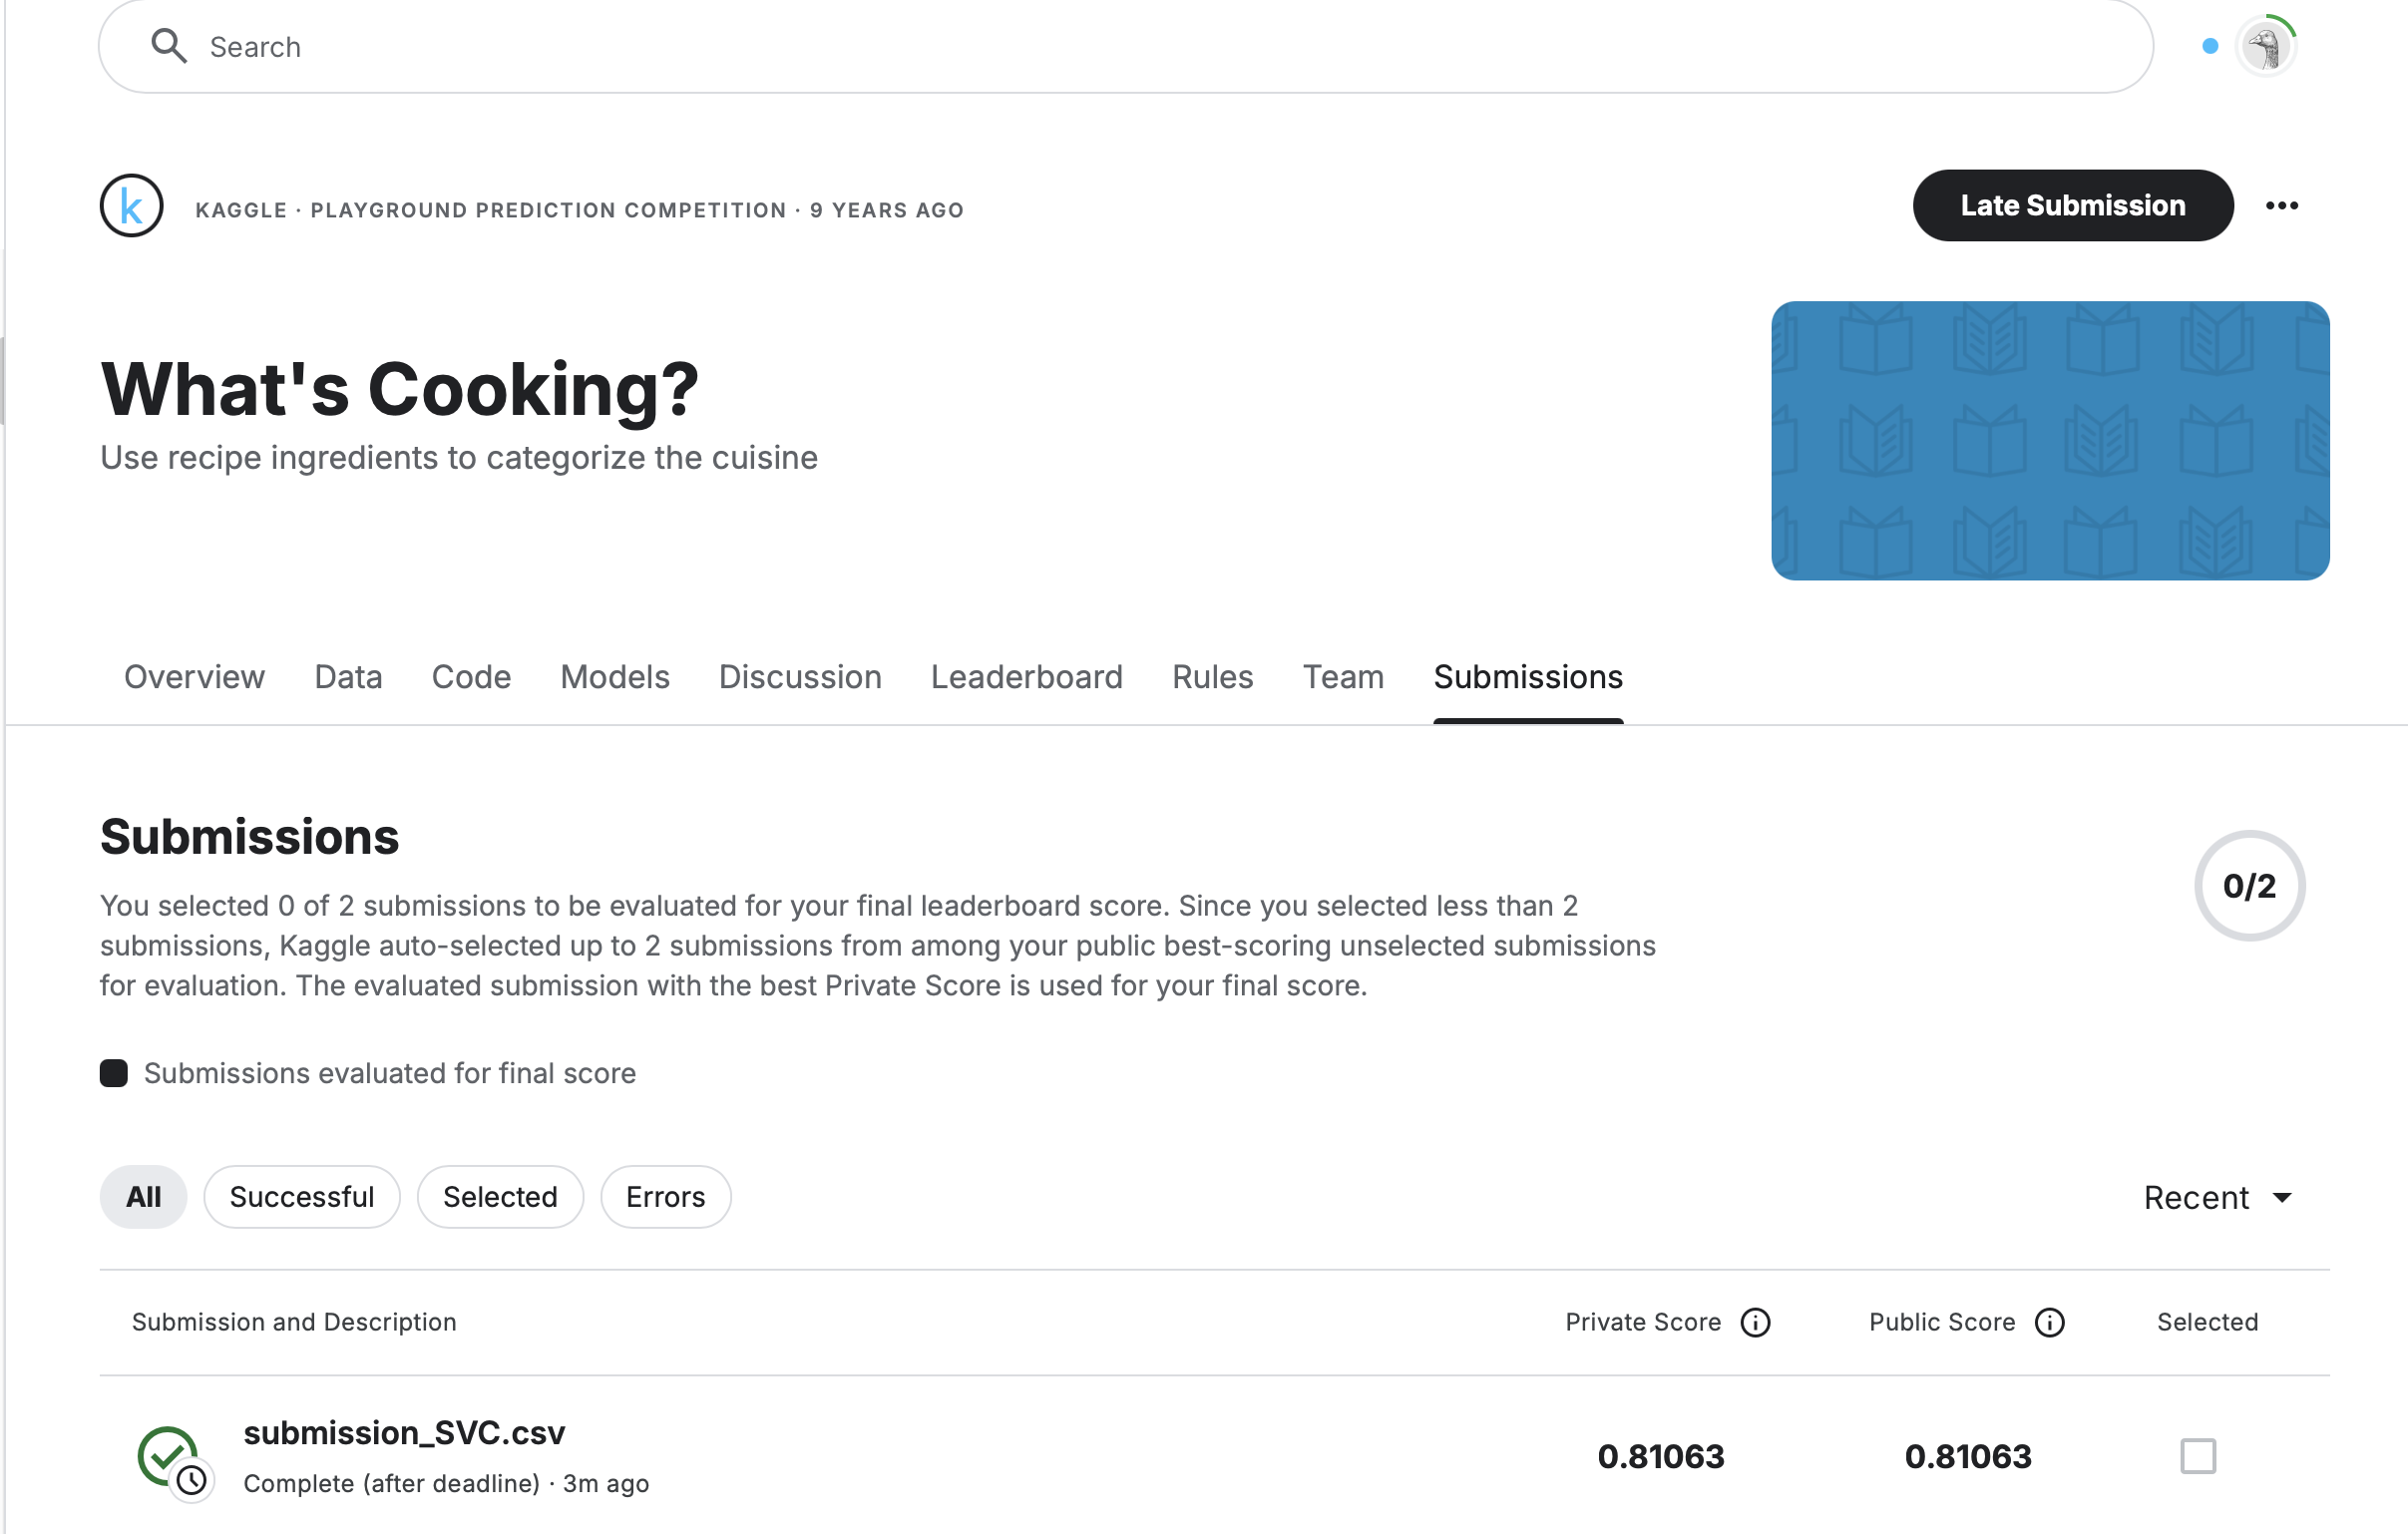